# Final Project - Predict Future Sales

The competition can be found here: https://www.kaggle.com/c/competitive-data-science-predict-future-sales  
The coursera course can be found here: https://www.coursera.org/



-----

#### Packages

In [1]:
import os
import pandas as pd
import numpy as np

from itertools import product

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

for p in [np, pd]:
    print (p.__name__, p.__version__)

numpy 1.14.5
pandas 0.23.1


In [2]:
data_folder_loc = '../00_data'

#### Import Data

In [3]:
sales = pd.read_csv(os.path.join(data_folder_loc, 'sales_train.csv.gz'))
test = pd.read_csv(os.path.join(data_folder_loc, 'test.csv.gz'))
submission = pd.read_csv(os.path.join(data_folder_loc, 'sample_submission.csv.gz'))
items = pd.read_csv(os.path.join(data_folder_loc, 'items.csv'))
item_categories = pd.read_csv(os.path.join(data_folder_loc, 'item_categories.csv'))
shops = pd.read_csv(os.path.join(data_folder_loc, 'shops.csv'))

In [4]:
# I few checks for me

# checking if the shop_ids are all present in the shops-data
print('shop IDs are inside shop data - testing test:  ', test['shop_id'].isin(shops['shop_id']).all())
print('shop IDs are inside shop data - testing train: ', sales['shop_id'].isin(shops['shop_id']).all())
print()
# checking if the item_ids are all present in item-data
print('item IDs are inside item data - testing test:  ', test['item_id'].isin(items['item_id']).all())
print('item IDs are inside item data - testing train: ', sales['item_id'].isin(items['item_id']).all())
print()
# checking if item-category_ids are all present in item-category-data
print('item IDs are inside item data - testing train: ', items['item_category_id'].isin(item_categories['item_category_id']).all())
print()

shop IDs are inside shop data - testing test:   True
shop IDs are inside shop data - testing train:  True

item IDs are inside item data - testing test:   True
item IDs are inside item data - testing train:  True

item IDs are inside item data - testing train:  True



# Cleaning & Re-formatting

#### Date
- correct the **date** format
- add **month**
- add **year**

In [5]:
# date - correct format
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')
# date - add month
sales['newcol_month'] = sales['date'].dt.month
# date - add year
sales['newcol_year'] = sales['date'].dt.year
# period
sales['newcol_period'] = sales['date'].apply(lambda x: str(x)[:7])

In [6]:
# index - for counting purposes
sales = sales.reset_index()

In [7]:
sales.head(9)

,index,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,newcol_month,newcol_year,newcol_period
0,0,2013-01-02,0,59,22154,999.00,1.0,1,2013,2013-01
1,1,2013-01-03,0,25,2552,899.00,1.0,1,2013,2013-01
2,2,2013-01-05,0,25,2552,899.00,-1.0,1,2013,2013-01
3,3,2013-01-06,0,25,2554,1709.05,1.0,1,2013,2013-01
4,4,2013-01-15,0,25,2555,1099.00,1.0,1,2013,2013-01
5,5,2013-01-10,0,25,2564,349.00,1.0,1,2013,2013-01
6,6,2013-01-02,0,25,2565,549.00,1.0,1,2013,2013-01
7,7,2013-01-04,0,25,2572,239.00,1.0,1,2013,2013-01
8,8,2013-01-11,0,25,2572,299.00,1.0,1,2013,2013-01


In [8]:
sales.rename(columns={'index':'newcol_ID'}, inplace=True)
sales.head()

,newcol_ID,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,newcol_month,newcol_year,newcol_period
0,0,2013-01-02,0,59,22154,999.00,1.0,1,2013,2013-01
1,1,2013-01-03,0,25,2552,899.00,1.0,1,2013,2013-01
2,2,2013-01-05,0,25,2552,899.00,-1.0,1,2013,2013-01
3,3,2013-01-06,0,25,2554,1709.05,1.0,1,2013,2013-01
4,4,2013-01-15,0,25,2555,1099.00,1.0,1,2013,2013-01


These are our sales features so far: 

In [9]:
for i in sales.columns:
    print('dtype ', sales[i].dtype.kind, ' for feature: ', i )
    
#A character code (one of ‘biufcmMOSUV’) identifying the general kind of data.
#b 	boolean
#i 	signed integer
#u 	unsigned integer
#f 	floating-point
#c 	complex floating-point
#m 	timedelta
#M 	datetime
#O 	object
#S 	(byte-)string
#U 	Unicode
#V 	void

dtype  i  for feature:  newcol_ID
dtype  M  for feature:  date
dtype  i  for feature:  date_block_num
dtype  i  for feature:  shop_id
dtype  i  for feature:  item_id
dtype  f  for feature:  item_price
dtype  f  for feature:  item_cnt_day
dtype  i  for feature:  newcol_month
dtype  i  for feature:  newcol_year
dtype  O  for feature:  newcol_period


# EDA - Exploratory Data Analysis
Before merging or aggregating the data sets, let's first look at what is presented to us:

In [10]:
print('train data      - shape: ', sales.shape)
print('test data       - shape: ', test.shape)
print('submission      - shape: ', submission.shape)
print('items           - shape: ', items.shape)
print('item_categories - shape: ', item_categories.shape)
print('shops           - shape: ', shops.shape)

train data      - shape:  (2935849, 10)
test data       - shape:  (214200, 3)
submission      - shape:  (214200, 2)
items           - shape:  (22170, 3)
item_categories - shape:  (84, 2)
shops           - shape:  (60, 2)


In [11]:
sales.head()
test.head()

,newcol_ID,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,newcol_month,newcol_year,newcol_period
0,0,2013-01-02,0,59,22154,999.00,1.0,1,2013,2013-01
1,1,2013-01-03,0,25,2552,899.00,1.0,1,2013,2013-01
2,2,2013-01-05,0,25,2552,899.00,-1.0,1,2013,2013-01
3,3,2013-01-06,0,25,2554,1709.05,1.0,1,2013,2013-01
4,4,2013-01-15,0,25,2555,1099.00,1.0,1,2013,2013-01


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [12]:
# aggregating to period
# counting the indexes - counting the number of records in each period
pivot_period = pd.pivot_table(data=sales[['newcol_period', 'newcol_ID']], index=['newcol_period'],  aggfunc='count')#.reset_index()
pivot_period.head()

,newcol_ID
newcol_period,
2013-01,115690
2013-02,108613
2013-03,121347
2013-04,94109
2013-05,91759


In [13]:
# the lowest 5 months
pivot_period.sort_values('newcol_ID')[0:5]

,newcol_ID
newcol_period,
2015-09,50588
2015-10,53514
2015-05,54548
2015-06,54617
2015-07,55549


In [14]:
# the highest 5 months
pivot_period.sort_values('newcol_ID', ascending=False)[0:5]

,newcol_ID
newcol_period,
2013-12,143246
2014-12,130786
2013-03,121347
2013-01,115690
2013-02,108613


In [15]:
print('The period starts at:  ', pivot_period.index.min())
print('         and ends at:  ', pivot_period.index.max())

The period starts at:   2013-01
         and ends at:   2015-10


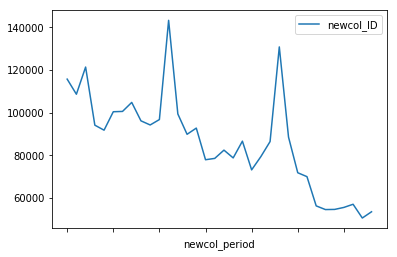

In [16]:
pivot_period.plot();

though you might not see it, the x-axis ( = period) is chronological.
There are two spikes in:
- December 2013
- December 2014 

I guess, these are the typical X-mas sales.  
Interesting to note is, that the records are dopping over time. If we would compare the number of records in 2013 and 2014, they should differ quite significantly.

In [17]:
# aggregating to year
# counting the indexes - counting the number of records in each period
pivot_year = pd.pivot_table(data=sales[['newcol_year', 'newcol_ID']], index=['newcol_year'],  aggfunc='count')#.reset_index()
pivot_year.head()
print('From 2013 to 2014, there is a drop of: ', (1-pivot_year['newcol_ID'].iloc[1]/pivot_year['newcol_ID'].iloc[0])*100, '%')

,newcol_ID
newcol_year,
2013,1267562
2014,1055861
2015,612426


From 2013 to 2014, there is a drop of:  16.7014315670555 %


**(!!)** the sales data set stops in October 2015, therefore don't consider 2015 here. 

### Outliers

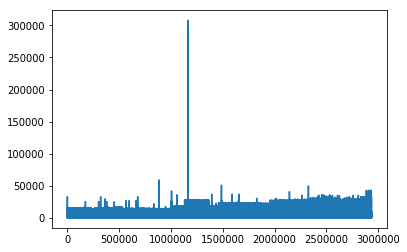

In [18]:
sales['item_price'].plot()

In [19]:
import matplotlib.pyplot as plt

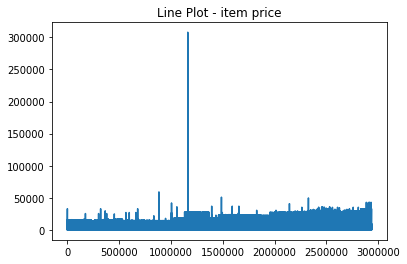

In [20]:
plt.plot(sales['item_price'])
plt.title('Line Plot - item price');

Plotting item price vs. number of products sold (per day)

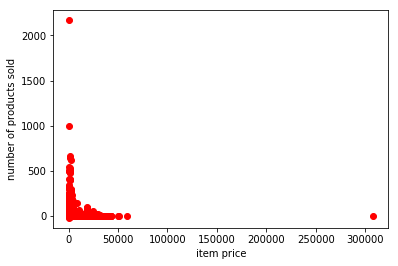

In [21]:
plt.plot(sales['item_price'], sales['item_cnt_day'], 'ro');
plt.xlabel('item price')
plt.ylabel('number of products sold');

Looking at the `item_price`, we see only one outlier.  
Looking at the `item_cnt_day`, there are two outlier.  
Let's remove them, because they don't add any value to the (upcoming) model.

In [22]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<=900]

# Monthly aggregation

Kaggle tells you the following about this featue: 
> `item_cnt_day` - number of products sold. You are predicting a monthly amount of this measure  


Because the feature `item_cnt_day` is per day, we have to aggregate the data on a monthly basis

In [23]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

#Compute all shops/items combinations
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [24]:
sales_m = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
sales_m = pd.merge(grid,sales_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

sales_m = pd.merge(sales_m,items,on=['item_id'],how='left')
sales_m = pd.merge(sales_m,item_categories, on=['item_category_id'], how='left')

In [25]:
sales_m.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id,item_category_name
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео


In [26]:
sales.head()

,newcol_ID,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,newcol_month,newcol_year,newcol_period
0,0,2013-01-02,0,59,22154,999.00,1.0,1,2013,2013-01
1,1,2013-01-03,0,25,2552,899.00,1.0,1,2013,2013-01
2,2,2013-01-05,0,25,2552,899.00,-1.0,1,2013,2013-01
3,3,2013-01-06,0,25,2554,1709.05,1.0,1,2013,2013-01
4,4,2013-01-15,0,25,2555,1099.00,1.0,1,2013,2013-01


next thing to do:
https://www.kaggle.com/the1owl/playing-in-the-sandbox  
https://www.kaggle.com/plasticgrammer/predict-future-sales-training


In [27]:
temp_test = test.copy()
temp_test['date_block_num'] = 34
temp_test.drop('ID', axis=1, inplace=True)

temp_test = temp_test.merge(items, how='left', on='item_id')
temp_test = temp_test.merge(item_categories, how='left', on='item_category_id')
temp_test.drop('item_name', axis=1, inplace=True)

In [28]:
sales_m.drop('item_name', axis=1, inplace=True)
sales_m = pd.concat([sales_m,temp_test], axis=0, ignore_index=True, sort=True)

In [29]:
sales_m.shape

(11128004, 7)

**Introducing mean encoding**: In one of the coursera videos, they recommend to add a mean encoding.


In [30]:
%%time
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id, agg_func, func_name in [('item_price', np.mean,'avg'),
                                           ('item_cnt_day', np.sum,'sum'),
                                           ('item_cnt_day', np.mean,'avg')]:

        mean_df = sales_m.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id,'date_block_num']
        
        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num', type_id],how='left')

Wall time: 1min 16s


**Introducing lag variables:** In one of the coursera videos, they recommend to add lagging variables. Now, because the data is now aggregated on a monthly basis, a lagging variables looks back 1,2,3,etc. month and adds that specific feature from that month int he current record:  

adding lag variables is quite time intensive. I checked the following lags:  
- lag 1 - 25.5s
- lag 1+2 - 42s
- lag 1+2+3 - 2min 15s  
- lag 1+2+3+4 - 4min 13s  
- lag 1+2+3+4+5+6 - 16min 2s
- lag 1+2+3+4+5+6+9+12 - 30min 21s  


However, using the data set witht he 12 lags, the  models take an eternity to train. This is has two reasons:
- the training data is around 5.3 GB big...which is way too big for my Microsoft Surface :)  
- and we have 85 features - hence, it will take even longer  
Therefore, I did reduce it to just 3 lag features

In [31]:
%%time
lag_variables  = ['item_id_avg_item_price',
                  'item_id_sum_item_cnt_day',
                  'item_id_avg_item_cnt_day',
                  'shop_id_avg_item_price',
                  'shop_id_sum_item_cnt_day',
                  'shop_id_avg_item_cnt_day',
                  'item_category_id_avg_item_price',
                  'item_category_id_sum_item_cnt_day',
                  'item_category_id_avg_item_cnt_day',
                  'item_cnt_day'
                 ]

#Limited by computation resource
lags = [1, 2, 3, 4, 5, 6]
#lags = [1, 2, 3, 4, 5, 6, 9, 12]

for lag in lags:
    sales_new_df = sales_m.copy()
    sales_new_df.date_block_num+=lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    sales_m = sales_m.merge(sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

Wall time: 16min 2s


**Missing values**  
for product counts: replace NA's with zero  
for product prices: replace NA's with the median

In [32]:
for feat in sales_m.columns:
    if 'item_cnt' in feat:
        sales_m[feat]=sales_m[feat].fillna(0)
    elif 'item_price' in feat:
        sales_m[feat]=sales_m[feat].fillna(sales_m[feat].median())

In [33]:
# Drop uneccesary columns and take data only after 12 since the most lag month interval is 12.
cols_to_drop = lag_variables[:-1] + ['item_price']
sales_m = sales_m[sales_m['date_block_num']>12]

In [34]:
# Validation
# We use holdout scheme for cross validation. We use sales month from 12 to 32 for training, 
# month 33 for validation and month 34 for testing.
X_train = sales_m[sales_m['date_block_num']<33].drop(cols_to_drop, axis=1)
X_cv =  sales_m[sales_m['date_block_num']==33].drop(cols_to_drop, axis=1)
X_test = sales_m[sales_m['date_block_num']==34].drop(cols_to_drop, axis=1)

In [35]:
# From discussion in Kaggle forum, we applied this useful trick, 
# which clip the item_cnt_day within 40 instead of 20. In this way, 
# there are more predictions on item_cnt_day = 20.

X_train['item_cnt_day'].clip_upper(40, inplace=True)
X_train['item_cnt_day'].clip_lower(0, inplace=True)

X_cv['item_cnt_day'].clip_upper(40, inplace=True)
X_cv['item_cnt_day'].clip_lower(0, inplace=True)

X_test['item_cnt_day'].clip_upper(40, inplace=True)
X_test['item_cnt_day'].clip_lower(0, inplace=True)

In [36]:
X_cv.head()

,date_block_num,item_category_id,item_category_name,item_cnt_day,item_id,shop_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,...,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6
10675632,33,47,"Книги - Комиксы, манга",1.0,13315,45,15.093023,1.0,0.023256,100.784209,...,39.980000,0.0,0.000000,100.215755,0.0,0.000000,45.573896,0.0,0.000000,0.0
10675633,33,55,Музыка - CD локального производства,1.0,13880,45,120.000000,57.0,1.325581,100.784209,...,137.091185,104.0,2.212766,90.449783,862.0,0.157414,46.329709,7162.0,0.213422,1.0
10675634,33,55,Музыка - CD локального производства,2.0,13881,45,313.388605,34.0,0.790698,100.784209,...,276.744681,36.0,0.765957,90.449783,862.0,0.157414,46.329709,7162.0,0.213422,0.0
10675635,33,40,Кино - DVD,1.0,13923,45,37.549884,15.0,0.348837,100.784209,...,48.659574,30.0,0.638298,90.449783,862.0,0.157414,29.276676,10683.0,0.233365,0.0
10675636,33,30,Игры PC - Стандартные издания,1.0,14227,45,71.839031,89.0,2.069767,100.784209,...,67.705621,114.0,2.425532,90.449783,862.0,0.157414,151.228978,14751.0,1.634641,0.0


In [37]:
X_train.drop('item_category_name', axis=1, inplace=True)

In [38]:
X_cv.drop('item_category_name', axis=1, inplace=True)

In [39]:
X_test.drop('item_category_name', axis=1, inplace=True)

In [40]:
X_test.head()

,date_block_num,item_category_id,item_cnt_day,item_id,shop_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,...,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6
10913804,34,19,0.0,5037,5,579.159091,25.0,0.568182,111.209795,1052.0,...,1202.773106,87.0,1.977273,103.231186,1012.0,0.191558,344.761915,3392.0,0.450824,1.0
10913805,34,55,0.0,5320,5,34.813953,0.0,0.000000,102.626336,0.0,...,39.980000,0.0,0.000000,100.215755,0.0,0.000000,45.573896,0.0,0.000000,0.0
10913806,34,19,0.0,5233,5,735.750000,42.0,0.954545,111.209795,1052.0,...,495.804545,71.0,1.613636,103.231186,1012.0,0.191558,344.761915,3392.0,0.450824,3.0
10913807,34,23,0.0,5232,5,511.909091,28.0,0.636364,111.209795,1052.0,...,39.980000,0.0,0.000000,100.215755,0.0,0.000000,45.573896,0.0,0.000000,0.0
10913808,34,20,0.0,5268,5,34.813953,0.0,0.000000,102.626336,0.0,...,39.980000,0.0,0.000000,100.215755,0.0,0.000000,45.573896,0.0,0.000000,0.0


In [41]:
%%time
X_train.to_csv('X_train.csv', index=False)
X_cv.to_csv('X_cv.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

Wall time: 11min 25s


In [42]:
X_train.shape

(5839576, 65)

In [43]:
X_cv.shape

(238172, 65)

In [44]:
X_test.shape

(214200, 65)